In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate XGBoost Model (Native API)
-- LOADS EXISTING MODEL --
-- UPDATED: Partial Dependence Plots now use LOG-ODDS --

Tasks:
1. Load dataset & replicate train/val/test splits (Random State 42).
2. Load saved native XGBoost model.
3. Re-determine best threshold from Validation set (Max F1).
4. Evaluate on Test set (Print metrics).
5. Generate Feature Importance Plot.
6. Generate Multi-panel Partial Dependence Plots (PDP) in LOG-ODDS.
7. Compare Predicted vs Observed Burned Area (Total & Yearly).
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pyarrow.dataset as ds
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.inspection import PartialDependenceDisplay

# ============================================================
# CONFIG (Must match Training Script)
# ============================================================

RANDOM_STATE = 42

# DATASET & MODEL PATHS
DATASET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "parquet_cems_with_fraction_dataset_burnedlab_mask_analytical"
)

# Directory where your model was saved
MODEL_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical"
)

MODEL_PATH = MODEL_DIR / "models" / "xgb_best_pr_auc.json"
FIGS_DIR = MODEL_DIR / "eval_figures"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity", 
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min", 
    "temperature_2m_max", "build_up_index", "drought_code", 
    "duff_moisture_code", "fine_fuel_moisture_code", 
    "fire_weather_index", "initial_fire_spread_index",
]

FRACTION_COL = "fraction"
LABEL_COL = "burned"

# We attempt to load 'year' for the area analysis. 
# If your dataset calls it 'time' or something else, update this.
YEAR_COL = "year" 

TEST_SIZE = 0.10
VAL_SIZE  = 0.20
THRESHOLDS = np.round(np.arange(0.05, 0.96, 0.05), 2)
N_JOBS = 6

# ============================================================
# HELPERS
# ============================================================

class XGBNativeSklearnWrapper:
    """
    A wrapper to make a native xgb.Booster look like an sklearn estimator.
    """
    def __init__(self, booster, feature_names):
        self.booster = booster
        self.feature_names = feature_names
        self.dummy_ = True
        self._estimator_type = "classifier"
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        # Returns Probabilities
        if isinstance(X, pd.DataFrame):
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        else:
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        
        preds = self.booster.predict(dmat)
        return np.vstack([1 - preds, preds]).T

    def decision_function(self, X):
        # NEW: Returns Log-Odds (Raw Margin)
        if isinstance(X, pd.DataFrame):
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        else:
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
            
        # output_margin=True gives the raw log-odds
        return self.booster.predict(dmat, output_margin=True)

def iou_from_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = tp + fp + fn
    return float(tp / denom) if denom > 0 else 0.0

def load_dataset(dataset_dir: Path) -> pd.DataFrame:
    print(f"Reading Parquet dataset from:\n  {dataset_dir}")
    dset = ds.dataset(str(dataset_dir), format="parquet")
    
    # Try to include Year column if it exists in schema
    all_cols = dset.schema.names
    cols_to_load = FEATURES + [FRACTION_COL]
    
    if YEAR_COL in all_cols:
        cols_to_load.append(YEAR_COL)
        print(f"Found '{YEAR_COL}' column, including it for analysis.")
    else:
        print(f"Warning: '{YEAR_COL}' column not found. Yearly analysis will be skipped.")

    table = dset.to_table(columns=cols_to_load)
    df = table.to_pandas()
    return df

def prepare_xy_with_meta(df: pd.DataFrame):
    df = df.copy()
    
    # 1. Clean Fraction
    df[FRACTION_COL] = pd.to_numeric(df[FRACTION_COL], errors="coerce").astype("float32")
    keep = df[FRACTION_COL].notna() & (df[FRACTION_COL] != 0.5)
    df = df.loc[keep].copy()
    
    # 2. Create Label
    df[LABEL_COL] = (df[FRACTION_COL] > 0.5).astype("uint8")
    
    # 3. Clean Features
    df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # 4. Drop NaNs
    req_cols = FEATURES + [LABEL_COL]
    if YEAR_COL in df.columns:
        req_cols.append(YEAR_COL)
        
    df = df.dropna(subset=req_cols).copy()

    # 5. Extract X, y, meta
    X = df[FEATURES].copy()
    y = df[LABEL_COL].astype("uint8").to_numpy()
    
    # Enforce dtypes
    X["b1"] = X["b1"].astype("int32")
    for c in X.columns:
        if c == "b1": continue
        X[c] = pd.to_numeric(X[c], errors="coerce").astype("float32")
    
    # Final NaN check on X
    mask = X.notna().all(axis=1)
    X = X.loc[mask].copy()
    y = y[mask.to_numpy()]
    
    # Meta (Year)
    meta = None
    if YEAR_COL in df.columns:
        meta = df.loc[mask, [YEAR_COL]].copy()

    return X, y, meta

# ============================================================
# MAIN
# ============================================================

def main():
    # 1. LOAD DATA & REPLICATE SPLIT
    # --------------------------------------------------------
    df = load_dataset(DATASET_DIR)
    X, y, meta = prepare_xy_with_meta(df)

    # To ensure X_test is identical to training, we must perform the exact same splits
    indices = np.arange(len(X))
    
    X_trainval, X_test, y_trainval, y_test, idx_trainval, idx_test = train_test_split(
        X, y, indices,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y,
    )

    # Split 2: Train / Val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_trainval,
    )
    
    # Meta for test set
    meta_test = None
    if meta is not None:
        meta_test = meta.iloc[idx_test].copy()

    print(f"\nData Loaded & Split Replicated.")
    print(f"Test Set Size: {len(X_test)}")

    # 2. LOAD MODEL
    # --------------------------------------------------------
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}")
    
    print(f"Loading model from: {MODEL_PATH}")
    booster = xgb.Booster()
    booster.load_model(str(MODEL_PATH))

    # 3. DETERMINE BEST THRESHOLD (ON VAL SET)
    # --------------------------------------------------------
    print("Re-calculating best threshold on Validation set (Max F1)...")
    dval = xgb.DMatrix(X_val, feature_names=FEATURES)
    val_probs = booster.predict(dval)
    
    best_f1 = -1
    best_thr = 0.5
    
    # Sweep thresholds
    for thr in THRESHOLDS:
        pred_tmp = (val_probs >= thr).astype(np.uint8)
        f1 = f1_score(y_val, pred_tmp, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            
    print(f"Best Validation Threshold: {best_thr} (F1: {best_f1:.4f})")

    # 4. TEST METRICS
    # --------------------------------------------------------
    dtest = xgb.DMatrix(X_test, feature_names=FEATURES)
    test_prob = booster.predict(dtest)
    
    test_pred = (test_prob >= best_thr).astype(np.uint8)
    
    test_pr_auc = average_precision_score(y_test, test_prob)
    test_prec = precision_score(y_test, test_pred, zero_division=0)
    test_rec  = recall_score(y_test, test_pred, zero_division=0)
    test_f1   = f1_score(y_test, test_pred, zero_division=0)
    test_iou  = iou_from_confusion(y_test, test_pred)

    print("\n=== TEST METRICS ===")
    print(f"Test PR-AUC (threshold-free): {test_pr_auc:.6f}")
    print(f"Threshold used: {best_thr:.2f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall    : {test_rec:.4f}")
    print(f"F1        : {test_f1:.4f}")
    print(f"IoU       : {test_iou:.4f}")

    print("\nArtifacts saved to:")
    print(f"  {MODEL_DIR}")
    print(f"Best model loaded from:\n  {MODEL_PATH}")

    # 5. FEATURE IMPORTANCE PLOT
    # --------------------------------------------------------
    print("\nGenerating Feature Importance Plot...")
    importance_type = 'total_gain' 
    imp = booster.get_score(importance_type=importance_type)
    imp_df = pd.DataFrame(list(imp.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(imp_df['Feature'], imp_df['Importance'], color='skyblue')
    plt.xlabel(f"Importance ({importance_type})")
    plt.title("XGBoost Feature Importance")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(FIGS_DIR / "feature_importance.png", dpi=200)
    plt.close()
    print(" Saved feature_importance.png")

    # 6. PARTIAL DEPENDENCE PLOTS (LOG-ODDS) 
    # --------------------------------------------------------
    print("\nGenerating Partial Dependence Plots (Log-Odds)...")
    top_features = imp_df.sort_values(by='Importance', ascending=False)['Feature'].head(9).tolist()
    
    sklearn_model = XGBNativeSklearnWrapper(booster, FEATURES)
    
    fig, ax = plt.subplots(figsize=(15, 12))
    X_pdp = X_test.sample(n=min(len(X_test), 5000), random_state=RANDOM_STATE) if len(X_test) > 5000 else X_test
    
    # Use response_method='decision_function' for Log-Odds
    display = PartialDependenceDisplay.from_estimator(
        sklearn_model,
        X_pdp,
        features=top_features,
        response_method="decision_function",  # <--- FORCE LOG-ODDS
        ax=ax,
        n_cols=3,
        grid_resolution=30,
        line_kw={"color": "darkblue", "linewidth": 2}
    )
    
    # Manually label Y-axis to be clear
    for sub_ax in display.axes_.flatten():
        sub_ax.set_ylabel("Partial Dependence (Log-Odds)")

    plt.suptitle(f"Partial Dependence Plots (Log-Odds) - Top {len(top_features)} Features", fontsize=16)
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.savefig(FIGS_DIR / "partial_dependence_plot_logodds.png", dpi=200)
    plt.close()
    print(" Saved partial_dependence_plot_logodds.png")

    # 7. BURNED AREA COMPARISON
    # --------------------------------------------------------
    print("\nComparing Burned Areas...")
    res_df = pd.DataFrame({
        "observed_binary": y_test,
        "predicted_binary": test_pred,
        "predicted_prob": test_prob
    })
    
    if meta_test is not None:
        res_df[YEAR_COL] = meta_test[YEAR_COL].values
        yearly = res_df.groupby(YEAR_COL)[["observed_binary", "predicted_binary"]].sum().reset_index()
        yearly.rename(columns={
            "observed_binary": "Observed_Pixels", 
            "predicted_binary": "Predicted_Pixels"
        }, inplace=True)
        
        yearly.to_csv(FIGS_DIR / "burned_area_comparison_yearly.csv", index=False)
        
        plt.figure(figsize=(12, 6))
        x_idx = np.arange(len(yearly))
        width = 0.35
        
        plt.bar(x_idx - width/2, yearly["Observed_Pixels"], width, label='Observed (Label=1)', color='tab:orange', alpha=0.8)
        plt.bar(x_idx + width/2, yearly["Predicted_Pixels"], width, label=f'Predicted (Prob>{best_thr})', color='tab:blue', alpha=0.8)
        
        plt.xlabel("Year")
        plt.ylabel("Burned Area (Pixel Count)")
        plt.title("Observed vs Predicted Burned Area by Year (Test Set)")
        plt.xticks(x_idx, yearly[YEAR_COL], rotation=45)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(FIGS_DIR / "burned_area_yearly_comparison.png", dpi=200)
        plt.close()
        print(" Saved burned_area_yearly_comparison.png and .csv")
        
        print("\nYearly Burned Area Counts (Pixels):")
        print(yearly.to_string(index=False))
        
    else:
        print("\n[INFO] 'year' column not available. Calculating total sums only.")
        total_obs = res_df["observed_binary"].sum()
        total_pred = res_df["predicted_binary"].sum()
        print(f"Total Observed Pixels: {total_obs}")
        print(f"Total Predicted Pixels: {total_pred}")

if __name__ == "__main__":
    main()

Reading Parquet dataset from:
  /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical

Data Loaded & Split Replicated.
Test Set Size: 7458650
Loading model from: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical/models/xgb_best_pr_auc.json
Re-calculating best threshold on Validation set (Max F1)...
Best Validation Threshold: 0.95 (F1: 0.9640)

=== TEST METRICS ===
Test PR-AUC (threshold-free): 0.972710
Threshold used: 0.95
Precision: 0.9800
Recall    : 0.9460
F1        : 0.9627
IoU       : 0.9280

Artifacts saved to:
  /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical
Best model loaded from:
  /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical/models/xgb_best_pr_auc.json

Generating Feature Importance Plot...
 Saved feature_importance.png

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate XGBoost Model (Native API)
-- LOADS EXISTING MODEL --
-- UPDATED: Partial Dependence Plots now use LOG-ODDS --
-- UPDATED: Uses Fixed Probability Threshold (0.85) --

Tasks:
1. Load dataset & replicate train/val/test splits (Random State 42).
2. Load saved native XGBoost model.
3. Set fixed threshold (0.85).
4. Evaluate on Test set (Print metrics).
5. Generate Feature Importance Plot.
6. Generate Multi-panel Partial Dependence Plots (PDP) in LOG-ODDS.
7. Compare Predicted vs Observed Burned Area (Total & Yearly).
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pyarrow.dataset as ds
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.inspection import PartialDependenceDisplay

# ============================================================
# CONFIG (Must match Training Script)
# ============================================================

RANDOM_STATE = 42

# DATASET & MODEL PATHS
DATASET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "parquet_cems_with_fraction_dataset_burnedlab_mask_analytical"
)

# Directory where your model was saved
MODEL_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical"
)

MODEL_PATH = MODEL_DIR / "models" / "xgb_best_pr_auc.json"
FIGS_DIR = MODEL_DIR / "eval_figures"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity", 
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min", 
    "temperature_2m_max", "build_up_index", "drought_code", 
    "duff_moisture_code", "fine_fuel_moisture_code", 
    "fire_weather_index", "initial_fire_spread_index",
]

FRACTION_COL = "fraction"
LABEL_COL = "burned"

# We attempt to load 'year' for the area analysis. 
# If your dataset calls it 'time' or something else, update this.
YEAR_COL = "year" 

TEST_SIZE = 0.10
VAL_SIZE  = 0.20
# THRESHOLDS search range removed (using fixed 0.85)
N_JOBS = 6

# ============================================================
# HELPERS
# ============================================================

class XGBNativeSklearnWrapper:
    """
    A wrapper to make a native xgb.Booster look like an sklearn estimator.
    """
    def __init__(self, booster, feature_names):
        self.booster = booster
        self.feature_names = feature_names
        self.dummy_ = True
        self._estimator_type = "classifier"
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        # Returns Probabilities
        if isinstance(X, pd.DataFrame):
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        else:
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        
        preds = self.booster.predict(dmat)
        return np.vstack([1 - preds, preds]).T

    def decision_function(self, X):
        # NEW: Returns Log-Odds (Raw Margin)
        if isinstance(X, pd.DataFrame):
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        else:
            dmat = xgb.DMatrix(X, feature_names=self.feature_names)
            
        # output_margin=True gives the raw log-odds
        return self.booster.predict(dmat, output_margin=True)

def iou_from_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = tp + fp + fn
    return float(tp / denom) if denom > 0 else 0.0

def load_dataset(dataset_dir: Path) -> pd.DataFrame:
    print(f"Reading Parquet dataset from:\n  {dataset_dir}")
    dset = ds.dataset(str(dataset_dir), format="parquet")
    
    # Try to include Year column if it exists in schema
    all_cols = dset.schema.names
    cols_to_load = FEATURES + [FRACTION_COL]
    
    if YEAR_COL in all_cols:
        cols_to_load.append(YEAR_COL)
        print(f"Found '{YEAR_COL}' column, including it for analysis.")
    else:
        print(f"Warning: '{YEAR_COL}' column not found. Yearly analysis will be skipped.")

    table = dset.to_table(columns=cols_to_load)
    df = table.to_pandas()
    return df

def prepare_xy_with_meta(df: pd.DataFrame):
    df = df.copy()
    
    # 1. Clean Fraction
    df[FRACTION_COL] = pd.to_numeric(df[FRACTION_COL], errors="coerce").astype("float32")
    keep = df[FRACTION_COL].notna() & (df[FRACTION_COL] != 0.5)
    df = df.loc[keep].copy()
    
    # 2. Create Label
    df[LABEL_COL] = (df[FRACTION_COL] > 0.5).astype("uint8")
    
    # 3. Clean Features
    df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # 4. Drop NaNs
    req_cols = FEATURES + [LABEL_COL]
    if YEAR_COL in df.columns:
        req_cols.append(YEAR_COL)
        
    df = df.dropna(subset=req_cols).copy()

    # 5. Extract X, y, meta
    X = df[FEATURES].copy()
    y = df[LABEL_COL].astype("uint8").to_numpy()
    
    # Enforce dtypes
    X["b1"] = X["b1"].astype("int32")
    for c in X.columns:
        if c == "b1": continue
        X[c] = pd.to_numeric(X[c], errors="coerce").astype("float32")
    
    # Final NaN check on X
    mask = X.notna().all(axis=1)
    X = X.loc[mask].copy()
    y = y[mask.to_numpy()]
    
    # Meta (Year)
    meta = None
    if YEAR_COL in df.columns:
        meta = df.loc[mask, [YEAR_COL]].copy()

    return X, y, meta

# ============================================================
# MAIN
# ============================================================

def main():
    # 1. LOAD DATA & REPLICATE SPLIT
    # --------------------------------------------------------
    df = load_dataset(DATASET_DIR)
    X, y, meta = prepare_xy_with_meta(df)

    # To ensure X_test is identical to training, we must perform the exact same splits
    indices = np.arange(len(X))
    
    X_trainval, X_test, y_trainval, y_test, idx_trainval, idx_test = train_test_split(
        X, y, indices,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y,
    )

    # Split 2: Train / Val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=VAL_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_trainval,
    )
    
    # Meta for test set
    meta_test = None
    if meta is not None:
        meta_test = meta.iloc[idx_test].copy()

    print(f"\nData Loaded & Split Replicated.")
    print(f"Test Set Size: {len(X_test)}")

    # 2. LOAD MODEL
    # --------------------------------------------------------
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}")
    
    print(f"Loading model from: {MODEL_PATH}")
    booster = xgb.Booster()
    booster.load_model(str(MODEL_PATH))

    # 3. SET FIXED THRESHOLD
    # --------------------------------------------------------
    # Previous logic searched for Max F1 on Validation set.
    # New logic uses a hardcoded high-confidence threshold.
    best_thr = 0.85
    print(f"\nUsing Fixed Probability Threshold: {best_thr}")

    # 4. TEST METRICS
    # --------------------------------------------------------
    dtest = xgb.DMatrix(X_test, feature_names=FEATURES)
    test_prob = booster.predict(dtest)
    
    test_pred = (test_prob >= best_thr).astype(np.uint8)
    
    test_pr_auc = average_precision_score(y_test, test_prob)
    test_prec = precision_score(y_test, test_pred, zero_division=0)
    test_rec  = recall_score(y_test, test_pred, zero_division=0)
    test_f1   = f1_score(y_test, test_pred, zero_division=0)
    test_iou  = iou_from_confusion(y_test, test_pred)

    print("\n=== TEST METRICS ===")
    print(f"Test PR-AUC (threshold-free): {test_pr_auc:.6f}")
    print(f"Threshold used: {best_thr:.2f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall    : {test_rec:.4f}")
    print(f"F1        : {test_f1:.4f}")
    print(f"IoU       : {test_iou:.4f}")

    print("\nArtifacts saved to:")
    print(f"  {MODEL_DIR}")
    print(f"Best model loaded from:\n  {MODEL_PATH}")

    # 5. FEATURE IMPORTANCE PLOT
    # --------------------------------------------------------
    print("\nGenerating Feature Importance Plot...")
    importance_type = 'total_gain' 
    imp = booster.get_score(importance_type=importance_type)
    imp_df = pd.DataFrame(list(imp.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 8))
    plt.barh(imp_df['Feature'], imp_df['Importance'], color='skyblue')
    plt.xlabel(f"Importance ({importance_type})")
    plt.title("XGBoost Feature Importance")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(FIGS_DIR / "feature_importance.png", dpi=200)
    plt.close()
    print(" Saved feature_importance.png")

    # 6. PARTIAL DEPENDENCE PLOTS (LOG-ODDS) 
    # --------------------------------------------------------
    print("\nGenerating Partial Dependence Plots (Log-Odds)...")
    top_features = imp_df.sort_values(by='Importance', ascending=False)['Feature'].head(9).tolist()
    
    sklearn_model = XGBNativeSklearnWrapper(booster, FEATURES)
    
    fig, ax = plt.subplots(figsize=(15, 12))
    X_pdp = X_test.sample(n=min(len(X_test), 5000), random_state=RANDOM_STATE) if len(X_test) > 5000 else X_test
    
    # Use response_method='decision_function' for Log-Odds
    display = PartialDependenceDisplay.from_estimator(
        sklearn_model,
        X_pdp,
        features=top_features,
        response_method="decision_function",  # <--- FORCE LOG-ODDS
        ax=ax,
        n_cols=3,
        grid_resolution=30,
        line_kw={"color": "darkblue", "linewidth": 2}
    )
    
    # Manually label Y-axis to be clear
    for sub_ax in display.axes_.flatten():
        sub_ax.set_ylabel("Partial Dependence (Log-Odds)")

    plt.suptitle(f"Partial Dependence Plots (Log-Odds) - Top {len(top_features)} Features", fontsize=16)
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.savefig(FIGS_DIR / "partial_dependence_plot_logodds.png", dpi=200)
    plt.close()
    print(" Saved partial_dependence_plot_logodds.png")

    # 7. BURNED AREA COMPARISON
    # --------------------------------------------------------
    print("\nComparing Burned Areas...")
    res_df = pd.DataFrame({
        "observed_binary": y_test,
        "predicted_binary": test_pred,
        "predicted_prob": test_prob
    })
    
    if meta_test is not None:
        res_df[YEAR_COL] = meta_test[YEAR_COL].values
        yearly = res_df.groupby(YEAR_COL)[["observed_binary", "predicted_binary"]].sum().reset_index()
        yearly.rename(columns={
            "observed_binary": "Observed_Pixels", 
            "predicted_binary": "Predicted_Pixels"
        }, inplace=True)
        
        yearly.to_csv(FIGS_DIR / "burned_area_comparison_yearly.csv", index=False)
        
        plt.figure(figsize=(12, 6))
        x_idx = np.arange(len(yearly))
        width = 0.35
        
        plt.bar(x_idx - width/2, yearly["Observed_Pixels"], width, label='Observed (Label=1)', color='tab:orange', alpha=0.8)
        plt.bar(x_idx + width/2, yearly["Predicted_Pixels"], width, label=f'Predicted (Prob>{best_thr})', color='tab:blue', alpha=0.8)
        
        plt.xlabel("Year")
        plt.ylabel("Burned Area (Pixel Count)")
        plt.title("Observed vs Predicted Burned Area by Year (Test Set)")
        plt.xticks(x_idx, yearly[YEAR_COL], rotation=45)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(FIGS_DIR / "burned_area_yearly_comparison.png", dpi=200)
        plt.close()
        print(" Saved burned_area_yearly_comparison.png and .csv")
        
        print("\nYearly Burned Area Counts (Pixels):")
        print(yearly.to_string(index=False))
        
    else:
        print("\n[INFO] 'year' column not available. Calculating total sums only.")
        total_obs = res_df["observed_binary"].sum()
        total_pred = res_df["predicted_binary"].sum()
        print(f"Total Observed Pixels: {total_obs}")
        print(f"Total Predicted Pixels: {total_pred}")

if __name__ == "__main__":
    main()

Reading Parquet dataset from:
  /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical

Data Loaded & Split Replicated.
Test Set Size: 7458650
Loading model from: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical/models/xgb_best_pr_auc.json

Using Fixed Probability Threshold: 0.85

=== TEST METRICS ===
Test PR-AUC (threshold-free): 0.972710
Threshold used: 0.85
Precision: 0.9658
Recall    : 0.9519
F1        : 0.9588
IoU       : 0.9208

Artifacts saved to:
  /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical
Best model loaded from:
  /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_filtered_burnedlabmask_native_analytical/models/xgb_best_pr_auc.json

Generating Feature Importance Plot...
 Saved feature_importance.png

Generating Partial Dependence Plots (Log-Odds)...
 Saved parti

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Evaluate XGBoost Model (Temporal Split Version)
-- JUPYTER COMPATIBLE --
"""

import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pyarrow.dataset as ds
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.inspection import PartialDependenceDisplay

# ============================================================
# CONFIG
# ============================================================

RANDOM_STATE = 42

# DATASET
DATASET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "parquet_cems_with_fraction_dataset_burnedlab_mask_analytical"
)

# MODEL DIRECTORY (Where the temporal model was saved)
MODEL_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "ml_training/xgb_pr_auc_temporal_split_2003_2004"
)

# MODEL PATH
MODEL_PATH = MODEL_DIR / "models" / "xgb_best_pr_auc_temporal.json"

FIGS_DIR = MODEL_DIR / "eval_figures_diagnostics"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity", 
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min", 
    "temperature_2m_max", "build_up_index", "drought_code", 
    "duff_moisture_code", "fine_fuel_moisture_code", 
    "fire_weather_index", "initial_fire_spread_index",
]

FRACTION_COL = "fraction"
LABEL_COL = "burned"
YEAR_COL = "year"

# TEMPORAL SPLIT CONFIG
TEST_YEARS = [2003, 2004]
VAL_SIZE_OF_REMAINING = 0.20 

# Threshold for binary metrics
FIXED_THRESHOLD = 0.50 

# ============================================================
# HELPERS
# ============================================================

class XGBNativeSklearnWrapper:
    """Wrapper to make native xgb.Booster look like an sklearn estimator for PDP."""
    def __init__(self, booster, feature_names):
        self.booster = booster
        self.feature_names = feature_names
        self.dummy_ = True
        self._estimator_type = "classifier"
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        return self

    def predict_proba(self, X):
        dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        preds = self.booster.predict(dmat)
        return np.vstack([1 - preds, preds]).T

    def decision_function(self, X):
        # output_margin=True gives raw log-odds
        dmat = xgb.DMatrix(X, feature_names=self.feature_names)
        return self.booster.predict(dmat, output_margin=True)

def iou_from_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = tp + fp + fn
    return float(tp / denom) if denom > 0 else 0.0

def load_and_clean_data(dataset_dir: Path):
    """
    Loads data and cleans it, ensuring 'year' is present for temporal splitting.
    """
    print(f"Reading Parquet dataset from:\n  {dataset_dir}", flush=True)
    # partitioning="hive" is usually required if year is a folder level
    dset = ds.dataset(str(dataset_dir), format="parquet", partitioning="hive")
    
    # Check schema
    cols_available = dset.schema.names
    cols_to_load = FEATURES + [FRACTION_COL]
    
    if YEAR_COL in cols_available:
        cols_to_load.append(YEAR_COL)
    else:
        raise ValueError(f"Column '{YEAR_COL}' required for temporal split but not found.")

    table = dset.to_table(columns=cols_to_load)
    df = table.to_pandas()
    
    # Cleanup
    df[FRACTION_COL] = pd.to_numeric(df[FRACTION_COL], errors="coerce").astype("float32")
    df = df[df[FRACTION_COL].notna() & (df[FRACTION_COL] != 0.5)].copy()
    
    df[LABEL_COL] = (df[FRACTION_COL] > 0.5).astype("uint8")
    
    # Fix B1 and Year
    df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")
    df[YEAR_COL] = pd.to_numeric(df[YEAR_COL], errors="coerce").astype("Int64")
    
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Drop NaNs
    subset = FEATURES + [LABEL_COL, YEAR_COL]
    df = df.dropna(subset=subset).copy()
    
    # Final types
    df["b1"] = df["b1"].astype("int32")
    for c in FEATURES:
        if c == "b1": continue
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        
    return df

def get_X_y_meta(df):
    X = df[FEATURES].copy()
    y = df[LABEL_COL].astype("uint8").to_numpy()
    meta = df[[YEAR_COL]].copy()
    return X, y, meta


# ============================================================
# EXECUTION START
# ============================================================

# 1. LOAD DATA
# --------------------------------------------------------
df_clean = load_and_clean_data(DATASET_DIR)

# 2. REPLICATE TEMPORAL SPLIT
# --------------------------------------------------------
print(f"Splitting Data: Test Years {TEST_YEARS}", flush=True)

mask_test = df_clean[YEAR_COL].isin(TEST_YEARS)
df_test_full = df_clean.loc[mask_test]
df_trainval_full = df_clean.loc[~mask_test]

if len(df_test_full) == 0:
    raise ValueError(f"No data found for test years {TEST_YEARS}")

# Prepare arrays
X_test, y_test, meta_test = get_X_y_meta(df_test_full)
X_tv, y_tv, _ = get_X_y_meta(df_trainval_full)

# We need the Validation set to compare probability distributions
X_train, X_val, y_train, y_val = train_test_split(
    X_tv, y_tv,
    test_size=VAL_SIZE_OF_REMAINING,
    random_state=RANDOM_STATE,
    stratify=y_tv,
)

print(f"  Test Set ({TEST_YEARS}): {len(X_test):,} rows", flush=True)
print(f"  Validation Set (subset of rest): {len(X_val):,} rows", flush=True)

# 3. LOAD MODEL
# --------------------------------------------------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

print(f"Loading model from: {MODEL_PATH}", flush=True)
booster = xgb.Booster()
booster.load_model(str(MODEL_PATH))

# 4. PREDICT & DIAGNOSTICS
# --------------------------------------------------------
print("\nRunning Predictions...", flush=True)
dval = xgb.DMatrix(X_val, feature_names=FEATURES)
dtest = xgb.DMatrix(X_test, feature_names=FEATURES)

val_prob = booster.predict(dval)
test_prob = booster.predict(dtest)

# --- DIAGNOSTIC A: PROBABILITY DISTRIBUTION SHIFT ---
print("Generating Probability Distribution Shift Plot...", flush=True)
plt.figure(figsize=(10, 6))

# Plot histogram of probabilities for POSITIVE labels only
plt.hist(val_prob[y_val == 1], bins=50, alpha=0.5, label='Validation Positives', density=True)
plt.hist(test_prob[y_test == 1], bins=50, alpha=0.5, label=f'Test Positives ({TEST_YEARS})', density=True)

plt.title("Probability Distribution Shift (Positives Only)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

out_hist = FIGS_DIR / "prob_dist_shift.png"
plt.savefig(out_hist, dpi=150)
plt.close()
print(f" Saved {out_hist}", flush=True)

# 5. TEST METRICS (Fixed Threshold)
# --------------------------------------------------------
test_pred = (test_prob >= FIXED_THRESHOLD).astype(np.uint8)

test_pr_auc = average_precision_score(y_test, test_prob)
test_prec = precision_score(y_test, test_pred, zero_division=0)
test_rec  = recall_score(y_test, test_pred, zero_division=0)
test_f1   = f1_score(y_test, test_pred, zero_division=0)
test_iou  = iou_from_confusion(y_test, test_pred)

print("\n=== TEST METRICS ===", flush=True)
print(f"PR-AUC (Threshold Independent): {test_pr_auc:.6f}", flush=True)
print(f"Threshold used: {FIXED_THRESHOLD}", flush=True)
print(f"Precision: {test_prec:.4f}", flush=True)
print(f"Recall    : {test_rec:.4f}", flush=True)
print(f"F1        : {test_f1:.4f}", flush=True)
print(f"IoU       : {test_iou:.4f}", flush=True)

# 6. FEATURE IMPORTANCE & PDP
# --------------------------------------------------------
print("\nGenerating Feature Importance...", flush=True)
imp_dict = booster.get_score(importance_type='total_gain')
imp_df = pd.DataFrame(list(imp_dict.items()), columns=['Feature', 'Importance'])
imp_df = imp_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='skyblue')
plt.xlabel("Total Gain")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig(FIGS_DIR / "feature_importance.png", dpi=150)
plt.close()

print("Generating Partial Dependence (Log-Odds)...", flush=True)
top_features = imp_df.sort_values(by='Importance', ascending=False)['Feature'].head(9).tolist()
sklearn_model = XGBNativeSklearnWrapper(booster, FEATURES)

# Subsample for speed
X_pdp = X_test.sample(n=min(len(X_test), 5000), random_state=RANDOM_STATE)

fig, ax = plt.subplots(figsize=(15, 12))
display = PartialDependenceDisplay.from_estimator(
    sklearn_model,
    X_pdp,
    features=top_features,
    response_method="decision_function", # Log-odds
    ax=ax,
    n_cols=3,
    grid_resolution=30,
    line_kw={"color": "darkblue", "linewidth": 2}
)
for sub_ax in display.axes_.flatten():
    sub_ax.set_ylabel("Partial Dependence (Log-Odds)")
plt.suptitle("Partial Dependence (Log-Odds) - Test Set", fontsize=16)
plt.subplots_adjust(top=0.92, hspace=0.3)
plt.savefig(FIGS_DIR / "partial_dependence_logodds.png", dpi=150)
plt.close()

# 7. BURNED AREA COMPARISON
# --------------------------------------------------------
print("\nComparing Burned Areas...", flush=True)
res_df = pd.DataFrame({
    "observed_binary": y_test,
    "predicted_binary": test_pred,
    "year": meta_test[YEAR_COL].values
})

yearly = res_df.groupby("year")[["observed_binary", "predicted_binary"]].sum().reset_index()
yearly.columns = ["Year", "Observed_Pixels", "Predicted_Pixels"]

yearly.to_csv(FIGS_DIR / "burned_area_comparison.csv", index=False)

plt.figure(figsize=(8, 6))
x_idx = np.arange(len(yearly))
width = 0.35

plt.bar(x_idx - width/2, yearly["Observed_Pixels"], width, label='Observed', color='tab:orange', alpha=0.8)
plt.bar(x_idx + width/2, yearly["Predicted_Pixels"], width, label='Predicted', color='tab:blue', alpha=0.8)

plt.xticks(x_idx, yearly["Year"])
plt.ylabel("Pixel Count")
plt.title(f"Burned Area: Test Years (Thr={FIXED_THRESHOLD})")
plt.legend()
plt.tight_layout()
plt.savefig(FIGS_DIR / "burned_area_yearly.png", dpi=150)
plt.close()

print("\nYearly Breakdown:", flush=True)
print(yearly.to_string(index=False), flush=True)
print(f"\nDone. Results saved to {FIGS_DIR}", flush=True)

Reading Parquet dataset from:
  /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical
Splitting Data: Test Years [2003, 2004]
  Test Set ([2003, 2004]): 9,511,308 rows
  Validation Set (subset of rest): 13,015,037 rows
Loading model from: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_temporal_split_2003_2004/models/xgb_best_pr_auc_temporal.json

Running Predictions...
Generating Probability Distribution Shift Plot...
 Saved /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_temporal_split_2003_2004/eval_figures_diagnostics/prob_dist_shift.png

=== TEST METRICS ===
PR-AUC (Threshold Independent): 0.019825
Threshold used: 0.5
Precision: 0.0658
Recall    : 0.0008
F1        : 0.0017
IoU       : 0.0008

Generating Feature Importance...
Generating Partial Dependence (Log-Odds)...

Comparing Burned Areas...

Yearly Breakdown:
 Year  Observed_Pixels  Predicted_Pixels
 2003            28

In [2]:
import pyarrow.dataset as ds
from pathlib import Path

# The path you are trying to read
DATASET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "parquet_cems_with_fraction_dataset_burnedlab_mask_analytical"
)

def inspect_columns():
    print(f"Inspecting: {DATASET_DIR}")
    
    try:
        # Load dataset object (does not read full data, just schema/metadata)
        dataset = ds.dataset(str(DATASET_DIR), format="parquet")
        
        # Get all column names
        cols = dataset.schema.names
        
        print(f"\nFound {len(cols)} columns:")
        print("--------------------------------------------------")
        print(cols)
        print("--------------------------------------------------")
        
        # Check specifically for "year" (case-insensitive)
        year_candidates = [c for c in cols if "year" in c.lower() or "time" in c.lower() or "date" in c.lower()]
        
        if year_candidates:
            print(f"\nPossible time-related columns found: {year_candidates}")
        else:
            print("\nNo obvious 'year', 'time', or 'date' columns found.")
            
    except Exception as e:
        print(f"Error reading dataset: {e}")

if __name__ == "__main__":
    inspect_columns()

Inspecting: /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical

Found 19 columns:
--------------------------------------------------
['DEM', 'slope', 'aspect', 'b1', 'relative_humidity', 'total_precipitation_sum', 'temperature_2m', 'temperature_2m_min', 'temperature_2m_max', 'build_up_index', 'drought_code', 'duff_moisture_code', 'fine_fuel_moisture_code', 'fire_weather_index', 'initial_fire_spread_index', 'fraction', 'burned_pixel', 'longitude', 'latitude']
--------------------------------------------------

No obvious 'year', 'time', or 'date' columns found.


Loading model from: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_temporal_split_2003_2004/models/xgb_best_pr_auc_temporal.json

=== FEATURE IMPORTANCE (Total Gain) ===
                    Feature         Gain
11       duff_moisture_code  176305920.0
9            build_up_index  133733224.0
10             drought_code   44027412.0
4         relative_humidity   41658844.0
8        temperature_2m_max   36435028.0
5   total_precipitation_sum   35740504.0
6            temperature_2m   34386928.0
0                       DEM   32631598.0
7        temperature_2m_min   31890110.0
12  fine_fuel_moisture_code   31301266.0

Top Suspect Feature: duff_moisture_code

Loading data for duff_moisture_code to check for shifts...
Train/Val Mean: -51.6529
Test Mean:      -121.2161
Saved histogram to /panfs/ccds02/home/spotter5/fire_projections/diagnostic_shift.png


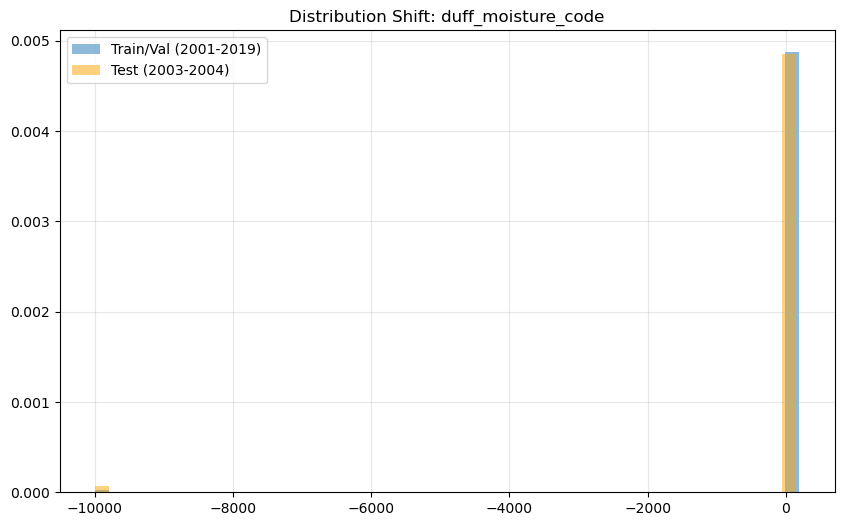

In [3]:
#!/usr/bin/env python3
"""
Diagnostic: Identify the 'Cheat' Feature
1. Loads the saved model.
2. Prints Feature Importance (Gain).
3. Plots the histogram of the Top Feature (Train vs Test) to see the shift.
"""

import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyarrow.dataset as ds
from pathlib import Path

# CONFIG (Must match your paths)
MODEL_PATH = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_pr_auc_temporal_split_2003_2004/models/xgb_best_pr_auc_temporal.json")
DATASET_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical")

FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity", 
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min", 
    "temperature_2m_max", "build_up_index", "drought_code", 
    "duff_moisture_code", "fine_fuel_moisture_code", 
    "fire_weather_index", "initial_fire_spread_index",
]
TEST_YEARS = [2003, 2004]

def main():
    # 1. Load Model and Get Importance
    print(f"Loading model from: {MODEL_PATH}")
    booster = xgb.Booster()
    booster.load_model(str(MODEL_PATH))
    
    # Get Importance (Total Gain is best for identifying heavy lifters)
    importance = booster.get_score(importance_type='total_gain')
    imp_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
    imp_df = imp_df.sort_values(by='Gain', ascending=False)
    
    print("\n=== FEATURE IMPORTANCE (Total Gain) ===")
    print(imp_df.head(10))
    
    top_feature = imp_df.iloc[0]['Feature']
    print(f"\nTop Suspect Feature: {top_feature}")
    
    # 2. Load Data for the Top Feature ONLY
    print(f"\nLoading data for {top_feature} to check for shifts...")
    dset = ds.dataset(str(DATASET_DIR), format="parquet", partitioning="hive")
    cols = [top_feature, "year"]
    
    table = dset.to_table(columns=cols)
    df = table.to_pandas()
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    
    # 3. Compare Distributions
    val_data = df[~df['year'].isin(TEST_YEARS)][top_feature].dropna()
    test_data = df[df['year'].isin(TEST_YEARS)][top_feature].dropna()
    
    print(f"Train/Val Mean: {val_data.mean():.4f}")
    print(f"Test Mean:      {test_data.mean():.4f}")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(val_data, bins=50, alpha=0.5, label='Train/Val (2001-2019)', density=True)
    plt.hist(test_data, bins=50, alpha=0.5, label='Test (2003-2004)', density=True, color='orange')
    plt.title(f"Distribution Shift: {top_feature}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save to current directory so you can open it
    out_file = Path("diagnostic_shift.png")
    plt.savefig(out_file)
    print(f"Saved histogram to {out_file.absolute()}")

if __name__ == "__main__":
    main()